In [90]:
# imports 
import numpy as np
from math import sqrt 
from pprint import pprint
from numpy import array
import pandas as pd
from time import time


import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.preprocessing import LabelEncoder, StandardScaler

In [91]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [92]:
# load data
df=pd.read_csv('/content/drive/MyDrive/data/UNSW_2018_IoT_Botnet_Final_10_Best.csv',sep=";")  

del df['Unnamed: 0']
#df['outlier'] = df.outlier.apply(lambda label: 1 if label == "'yes'" else 0)

df.head()

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,1,tcp,192.168.100.147,49960,192.168.100.7,80,9,0.068909,75,0.000000,1,0.068909,96,14.511893,0.566862,0.137818,1,DoS,HTTP
1,2,arp,192.168.100.7,-1,192.168.100.147,-1,10,0.000000,2,0.000131,2,0.000131,1,0.000000,0.000000,0.000131,1,DoS,HTTP
2,3,tcp,192.168.100.147,49962,192.168.100.7,80,11,0.064494,75,0.000000,1,0.064494,96,15.505319,0.567549,0.128988,1,DoS,HTTP
3,4,tcp,192.168.100.147,49964,192.168.100.7,80,12,0.064189,75,0.000000,1,0.064189,96,15.578993,0.567570,0.128378,1,DoS,HTTP
4,5,tcp,192.168.100.147,49966,192.168.100.7,80,13,0.063887,75,0.000000,1,0.063887,96,15.652637,0.567630,0.127774,1,DoS,HTTP


In [93]:
df = df.sample(frac=1)
df.shape

(3668522, 19)

In [94]:
pd.value_counts(df.attack)

1    3668045
0        477
Name: attack, dtype: int64

In [95]:
#df = df.iloc[:10000]

In [96]:
pd.value_counts(df.attack)

1    3668045
0        477
Name: attack, dtype: int64

In [97]:
df.columns = df.columns.to_series().apply(lambda x: x.strip())
df = df.reset_index(drop=True)

# General Information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3668522 entries, 0 to 3668521
Data columns (total 19 columns):
 #   Column             Dtype  
---  ------             -----  
 0   pkSeqID            int64  
 1   proto              object 
 2   saddr              object 
 3   sport              object 
 4   daddr              object 
 5   dport              object 
 6   seq                int64  
 7   stddev             float64
 8   N_IN_Conn_P_SrcIP  int64  
 9   min                float64
 10  state_number       int64  
 11  mean               float64
 12  N_IN_Conn_P_DstIP  int64  
 13  drate              float64
 14  srate              float64
 15  max                float64
 16  attack             int64  
 17  category           object 
 18  subcategory        object 
dtypes: float64(6), int64(6), object(7)
memory usage: 531.8+ MB


# Exploratory Data Analysis

In [98]:
df.describe()

,pkSeqID,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack
count,3.668522e+06,3.668522e+06,3.668522e+06,3.668522e+06,3.668522e+06,3.668522e+06,3.668522e+06,3.668522e+06,3.668522e+06,3.668522e+06,3.668522e+06,3.668522e+06
mean,1.834262e+06,1.213204e+05,8.871499e-01,8.253848e+01,1.017540e+00,3.134390e+00,2.231063e+00,9.245168e+01,4.455046e-01,2.955111e+00,3.020015e+00,9.998700e-01
std,1.059011e+06,7.579428e+04,8.037139e-01,2.439739e+01,1.483688e+00,1.186971e+00,1.517728e+00,1.817643e+01,6.028863e+01,7.245425e+02,1.860877e+00,1.140212e-02
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.171312e+05,5.487600e+04,3.001900e-02,6.900000e+01,0.000000e+00,3.000000e+00,1.819670e-01,1.000000e+02,0.000000e+00,1.559700e-01,2.806072e-01,1.000000e+00
50%,1.834262e+06,1.177690e+05,7.938960e-01,1.000000e+02,0.000000e+00,4.000000e+00,2.690125e+00,1.000000e+02,0.000000e+00,2.837830e-01,4.009111e+00,1.000000e+00
75%,2.751392e+06,1.849300e+05,1.745296e+00,1.000000e+02,2.151138e+00,4.000000e+00,3.565203e+00,1.000000e+02,0.000000e+00,4.882010e-01,4.293582e+00,1.000000e+00
max,3.668522e+06,2.622120e+05,2.496763e+00,1.000000e+02,4.980471e+00,1.100000e+01,4.981882e+00,1.000000e+02,5.882353e+04,1.000000e+06,4.999999e+00,1.000000e+00


# Extracting 10 best features

In [99]:
ten_best_features = df[['seq','stddev','N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP',
       'drate', 'srate', 'max','attack']]
#target_features = df[['attack','category','subcategory']]

# Data Preprocessing


In [100]:
# Label Encoding the target columns

#le = LabelEncoder()
#target_features['category'] = le.fit_transform(target_features['category'])
#target_features['subcategory'] = le.fit_transform(target_features['subcategory'])

#target_features.head()

In [101]:
from sklearn.model_selection import train_test_split

ten_best_features = ten_best_features.values

y = ten_best_features[:,10]
X = ten_best_features[:,0:10]

# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)


# Scaling the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [102]:
# number of class
len(np.unique(y_train))

2

# Extratrees Deep

In [103]:
# Insert the directory
import sys
sys.path.insert(0,'/content/drive/My Drive/')

In [104]:
# Extratrees Deep
import argparse
import sys
import pickle
from sklearn.metrics import accuracy_score
sys.path.insert(0, "lib")
from gcforest.gcforest import GCForest
from gcforest.utils.config_utils import load_json
config = load_json("/content/drive/My Drive/examples/attack.json")
gc = GCForest(config)

In [105]:
# X_enc is the concatenated predict_proba result of DeepExtraTrees
X_train_enc, X_test_enc = gc.fit_transform(X_train, y_train, X_test=X_test, y_test=y_test)

INFO:gcforest.cascade.cascade_classifier:X_groups_train.shape=[(2567965, 10)],y_train.shape=(2567965,),X_groups_test.shape=[(1100557, 10)],y_test.shape=(1100557,)
INFO:gcforest.cascade.cascade_classifier:group_dims=[10]
INFO:gcforest.cascade.cascade_classifier:group_starts=[0]
INFO:gcforest.cascade.cascade_classifier:group_ends=[10]
INFO:gcforest.cascade.cascade_classifier:X_train.shape=(2567965, 10),X_test.shape=(1100557, 10)
INFO:gcforest.cascade.cascade_classifier:[layer=0] look_indexs=[0], X_cur_train.shape=(2567965, 10), X_cur_test.shape=(1100557, 10)
INFO:gcforest.estimators.kfold_wrapper:Accuracy(layer_0 - estimator_0 - 10_folds.train_0.predict)=100.00%
INFO:gcforest.estimators.kfold_wrapper:Accuracy(layer_0 - estimator_0 - 10_folds.train_1.predict)=100.00%
INFO:gcforest.estimators.kfold_wrapper:Accuracy(layer_0 - estimator_0 - 10_folds.train_2.predict)=100.00%
INFO:gcforest.estimators.kfold_wrapper:Accuracy(layer_0 - estimator_0 - 10_folds.train_3.predict)=100.00%
INFO:gcforest

In [106]:
# predict
y_pred = gc.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy of DeepExtratTrees = {:.6f} %".format(acc * 100))
 # Matrix de confusion
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

INFO:gcforest.cascade.cascade_classifier:X_groups_test.shape=[(1100557, 10)]
INFO:gcforest.cascade.cascade_classifier:group_dims=[10]
INFO:gcforest.cascade.cascade_classifier:X_test.shape=(1100557, 10)
INFO:gcforest.cascade.cascade_classifier:[layer=0] look_indexs=[0], X_cur_test.shape=(1100557, 10)


Test Accuracy of DeepExtratTrees = 99.999182 %
[[    140       8]
 [      1 1100408]]


              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       148
         1.0       1.00      1.00      1.00   1100409

    accuracy                           1.00   1100557
   macro avg       1.00      0.97      0.98   1100557
weighted avg       1.00      1.00      1.00   1100557



[2023-01-08 22:02:55.822] Start to evalute the model:
[2023-01-08 22:02:56.449] Evaluating cascade layer = 0 


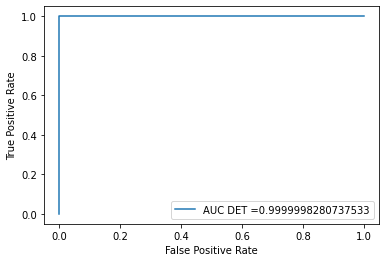

In [120]:
#define metrics
from sklearn.metrics import roc_auc_score

y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC DET ="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# **CascadeForestClassifier**

In [109]:
#!pip install deep-forest

In [110]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from deepforest import CascadeForestClassifier


model = CascadeForestClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred) * 100
print("\nTesting Accuracy: {:.3f} %".format(acc))

[2023-01-08 21:27:41.526] Start to fit the model:
[2023-01-08 21:27:41.527] Fitting cascade layer = 0 
[2023-01-08 21:40:38.823] layer = 0  | Val Acc = 99.999 % | Elapsed = 777.297 s
[2023-01-08 21:40:39.425] Fitting cascade layer = 1 
[2023-01-08 21:48:34.944] layer = 1  | Val Acc = 99.999 % | Elapsed = 475.519 s
[2023-01-08 21:48:34.946] Early stopping counter: 1 out of 2
[2023-01-08 21:48:35.437] Fitting cascade layer = 2 
[2023-01-08 21:57:39.764] layer = 2  | Val Acc = 99.999 % | Elapsed = 544.326 s
[2023-01-08 21:57:39.766] Early stopping counter: 2 out of 2
[2023-01-08 21:57:39.767] Handling early stopping
[2023-01-08 21:57:39.771] The optimal number of layers: 1
[2023-01-08 21:57:39.806] Start to evalute the model:
[2023-01-08 21:57:40.416] Evaluating cascade layer = 0 

Testing Accuracy: 99.999 %


In [119]:
# predict
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy of DET = {:.6f} %".format(acc * 100))
 # Matrix de confusion
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

[2023-01-08 22:02:35.917] Start to evalute the model:
[2023-01-08 22:02:36.543] Evaluating cascade layer = 0 
Test Accuracy of DET = 99.999091 %
[[    138      10]
 [      0 1100409]]


              precision    recall  f1-score   support

         0.0       1.00      0.93      0.97       148
         1.0       1.00      1.00      1.00   1100409

    accuracy                           1.00   1100557
   macro avg       1.00      0.97      0.98   1100557
weighted avg       1.00      1.00      1.00   1100557



[2023-01-08 22:01:57.015] Start to evalute the model:
[2023-01-08 22:01:57.654] Evaluating cascade layer = 0 
DET Confusion matrix, without normalization
[[    138      10]
 [      0 1100409]]
[2023-01-08 22:02:16.793] Start to evalute the model:
[2023-01-08 22:02:17.545] Evaluating cascade layer = 0 
DET Normalized confusion matrix
[[0.93 0.07]
 [0.   1.  ]]


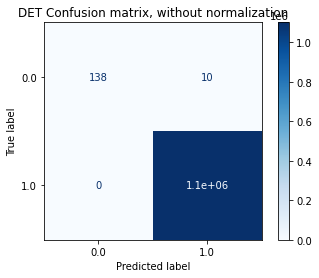

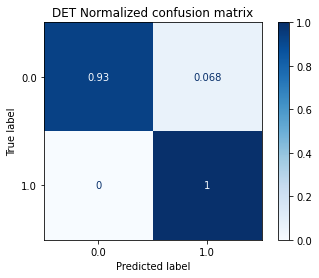

In [118]:
# Plot non-normalized confusion matrix
#np.set_printoptions(precision=2)

titles_options = [
    ("DET Confusion matrix, without normalization", None),
    ("DET Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        #display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

[2023-01-08 22:01:38.534] Start to evalute the model:
[2023-01-08 22:01:39.187] Evaluating cascade layer = 0 


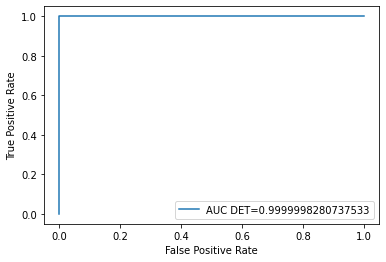

In [117]:
#define metrics
from sklearn import metrics

y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr,label="AUC DET="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()